In [2]:
import pandas as pd
from dateutil import rrule
import numpy as np
import datetime as dt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Read in datas from files
trans_data = pd.read_csv('detailed_txns.csv')
cap_data = pd.read_csv('capacity.csv')

In [4]:
trans_data['parking_transaction_date_time'] = pd.to_datetime(trans_data['parking_transaction_date_time'])
trans_data.head()

,Unnamed: 0,period,study_area,sub_area,area_subarea,parking_transaction_date_time,paymen_tmean,transaction_amount,paidduration_in_minutes,source_element_key
0,0,Afternoon,University District,Edge,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,2022-03-25 16:23:00,PHONE,0.04,5,1433
1,1,Morning,South Lake Union,North,EASTLAKE AVE E BETWEEN ALOHA ST AND WARD ST,2022-03-25 08:00:00,PHONE,0.98,118,10165
2,2,Morning,University District,Edge,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,2022-03-25 08:00:00,CREDIT CARD,2.00,240,1433
3,3,Morning,University District,Edge,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,2022-03-25 09:29:00,PHONE,0.50,60,1433
4,4,Morning,South Lake Union,North,FAIRVIEW NR AVE N BETWEEN FAIRVIEW PL N AND AL...,2022-03-25 09:29:00,PHONE,0.33,40,94602


In [5]:
# compute naive occupancy from transactions data
# treat that car occupancy is directly the start and end time of the paying period
input_data = {}
for _,row in trans_data.iterrows():
    start_time = row['parking_transaction_date_time']
    end_time = row['parking_transaction_date_time'] + pd.Timedelta(minutes=row['paidduration_in_minutes'])
    block_name = row['area_subarea']
    if block_name not in input_data:
        input_data[block_name] = {}
    for dt in rrule.rrule(rrule.MINUTELY, dtstart=start_time, until=end_time):
        if dt not in input_data[block_name]:
            input_data[block_name][dt] = 1
        else:
            input_data[block_name][dt] = input_data[block_name][dt] + 1

In [6]:
# test the computed naive occupancy data
time = trans_data['parking_transaction_date_time'].iloc[0]
name = trans_data['area_subarea'].iloc[0]
print(time)
print(name)
print(input_data[name][time])

2022-03-25 16:23:00
11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST
14


In [7]:
# convert to pandas dataframe and sort by time and date
data = pd.DataFrame.from_dict(input_data, orient='columns')
data = data.fillna(0)
data = data.sort_index()

data

,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,EASTLAKE AVE E BETWEEN ALOHA ST AND WARD ST,FAIRVIEW NR AVE N BETWEEN FAIRVIEW PL N AND ALOHA ST,15TH AVE NE BETWEEN NE 43RD ST AND NE 45TH ST,7TH AVE BETWEEN OLIVE WAY AND STEWART ST,6TH AVE N BETWEEN JOHN ST AND THOMAS ST,MINOR AVE BETWEEN HOWELL ST AND STEWART ST,1ST AVE BETWEEN BELL ST AND BATTERY ST,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,BOYLSTON AVE BETWEEN E PIKE ST AND E PINE ST,FAIRVIEW AVE N BETWEEN JOHN ST AND THOMAS ST
2022-03-21 08:00:00,8.0,7.0,4.0,0.0,1.0,24.0,5.0,1.0,0.0,9.0,0.0,1.0
2022-03-21 08:01:00,8.0,7.0,4.0,0.0,1.0,24.0,5.0,1.0,0.0,9.0,0.0,1.0
2022-03-21 08:02:00,9.0,7.0,4.0,1.0,1.0,25.0,8.0,1.0,0.0,10.0,0.0,1.0
2022-03-21 08:03:00,9.0,7.0,4.0,1.0,1.0,25.0,9.0,1.0,0.0,10.0,0.0,1.0
2022-03-21 08:04:00,9.0,7.0,4.0,1.0,1.0,25.0,9.0,1.0,0.0,11.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 21:56:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-03-28 21:57:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-03-28 21:58:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-03-28 21:59:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
# remove anytime not between 8:00-19:59 to match gt_occupancy data
# sort by name of the area
unwanted = ['00', '01', '02', '03', '04', '05', '06', '07', '20', '21', '22', '23', '24']
for index, row in data.iterrows():
    if index.strftime('%H') in unwanted:
        data = data.drop(index, axis=0) 
data_processed = data.sort_index(axis=1)
data_processed

,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,15TH AVE NE BETWEEN NE 43RD ST AND NE 45TH ST,1ST AVE BETWEEN BELL ST AND BATTERY ST,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,6TH AVE N BETWEEN JOHN ST AND THOMAS ST,7TH AVE BETWEEN OLIVE WAY AND STEWART ST,BOYLSTON AVE BETWEEN E PIKE ST AND E PINE ST,EASTLAKE AVE E BETWEEN ALOHA ST AND WARD ST,FAIRVIEW AVE N BETWEEN JOHN ST AND THOMAS ST,FAIRVIEW NR AVE N BETWEEN FAIRVIEW PL N AND ALOHA ST,MINOR AVE BETWEEN HOWELL ST AND STEWART ST,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N
2022-03-21 08:00:00,8.0,0.0,1.0,0.0,24.0,1.0,0.0,7.0,1.0,4.0,5.0,9.0
2022-03-21 08:01:00,8.0,0.0,1.0,0.0,24.0,1.0,0.0,7.0,1.0,4.0,5.0,9.0
2022-03-21 08:02:00,9.0,1.0,1.0,0.0,25.0,1.0,0.0,7.0,1.0,4.0,8.0,10.0
2022-03-21 08:03:00,9.0,1.0,1.0,0.0,25.0,1.0,0.0,7.0,1.0,4.0,9.0,10.0
2022-03-21 08:04:00,9.0,1.0,1.0,0.0,25.0,1.0,0.0,7.0,1.0,4.0,9.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 19:55:00,0.0,1.0,13.0,4.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0
2022-03-28 19:56:00,0.0,0.0,13.0,4.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0
2022-03-28 19:57:00,0.0,0.0,13.0,4.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0
2022-03-28 19:58:00,0.0,0.0,12.0,4.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# get the capacity for each area and compute the naive occupancy percentage
cap_data = cap_data.sort_index(axis=1)
cap_ref = cap_data.iloc[8,:12]
print(cap_ref)
naive_occ = data_processed
for i in range(cap_ref.size):
    naive_occ.loc[:,cap_ref.index[i]] = (data_processed.loc[:,cap_ref.index[i]]/cap_ref.iloc[i]).round(3)

11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST           28
15TH AVE NE BETWEEN NE 43RD ST AND NE 45TH ST            7
1ST AVE BETWEEN BELL ST AND BATTERY ST                  12
2ND AVE BETWEEN LENORA ST AND BLANCHARD ST               8
6TH AVE N BETWEEN JOHN ST AND THOMAS ST                 19
7TH AVE BETWEEN OLIVE WAY AND STEWART ST                 4
BOYLSTON AVE BETWEEN E PIKE ST AND E PINE ST             6
EASTLAKE AVE E BETWEEN ALOHA ST AND WARD ST             12
FAIRVIEW AVE N BETWEEN JOHN ST AND THOMAS ST            12
FAIRVIEW NR AVE N BETWEEN FAIRVIEW PL N AND ALOHA ST    24
MINOR AVE BETWEEN HOWELL ST AND STEWART ST              13
ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N           12
Name: 8, dtype: int64


In [10]:
#naive_occ.to_csv('./naive_occupancy.csv')
naive_occ

,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,15TH AVE NE BETWEEN NE 43RD ST AND NE 45TH ST,1ST AVE BETWEEN BELL ST AND BATTERY ST,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,6TH AVE N BETWEEN JOHN ST AND THOMAS ST,7TH AVE BETWEEN OLIVE WAY AND STEWART ST,BOYLSTON AVE BETWEEN E PIKE ST AND E PINE ST,EASTLAKE AVE E BETWEEN ALOHA ST AND WARD ST,FAIRVIEW AVE N BETWEEN JOHN ST AND THOMAS ST,FAIRVIEW NR AVE N BETWEEN FAIRVIEW PL N AND ALOHA ST,MINOR AVE BETWEEN HOWELL ST AND STEWART ST,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N
2022-03-21 08:00:00,0.286,0.000,0.083,0.0,1.263,0.25,0.0,0.583,0.083,0.167,0.385,0.750
2022-03-21 08:01:00,0.286,0.000,0.083,0.0,1.263,0.25,0.0,0.583,0.083,0.167,0.385,0.750
2022-03-21 08:02:00,0.321,0.143,0.083,0.0,1.316,0.25,0.0,0.583,0.083,0.167,0.615,0.833
2022-03-21 08:03:00,0.321,0.143,0.083,0.0,1.316,0.25,0.0,0.583,0.083,0.167,0.692,0.833
2022-03-21 08:04:00,0.321,0.143,0.083,0.0,1.316,0.25,0.0,0.583,0.083,0.167,0.692,0.917
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 19:55:00,0.000,0.143,1.083,0.5,0.053,1.00,1.0,0.000,0.000,0.000,0.000,0.000
2022-03-28 19:56:00,0.000,0.000,1.083,0.5,0.053,1.00,1.0,0.000,0.000,0.000,0.000,0.000
2022-03-28 19:57:00,0.000,0.000,1.083,0.5,0.053,1.00,1.0,0.000,0.000,0.000,0.000,0.000
2022-03-28 19:58:00,0.000,0.000,1.000,0.5,0.053,1.00,1.0,0.000,0.000,0.000,0.000,0.000


In [11]:
# convert the timestamp 8:00-19:00 to an interger 
time_index = pd.to_datetime(naive_occ.index, format='%H:%M').strftime('%H%M')
timestamp = []
for i in range(int(time_index.size/7)):
    timestamp.append(int(time_index[i]))

print(len(timestamp))

720


In [12]:
# Model Linear combination of time, capacity, and naive occupancy to generate actual occupancy
# Generate data matrix X containing 12 hours snapshot for one week across 12 different area
X_columns = 3
X_rows = 5040 * 12
X = np.zeros((X_rows,X_columns), dtype=float)
print(X.shape)
index = 0
for i in range(12):
    for j in range(7):
        for k in range(720):
            X[:][index] = [timestamp[k], cap_ref[i], naive_occ.iloc[j*720+k, i]]
            index = index + 1

(60480, 3)


In [13]:
print(X[5040,:])

[800.   7.   0.]


In [14]:
X_data = pd.DataFrame(X, columns = ['Time','Capcity','Naive Occupancy'])
X_data

,Time,Capcity,Naive Occupancy
0,800.0,28.0,0.286
1,801.0,28.0,0.286
2,802.0,28.0,0.321
3,803.0,28.0,0.321
4,804.0,28.0,0.321
...,...,...,...
60475,1955.0,12.0,0.000
60476,1956.0,12.0,0.000
60477,1957.0,12.0,0.000
60478,1958.0,12.0,0.000


In [15]:
#X_data.to_csv('./X_data.csv')

In [16]:
# Get true occupancy data
gt_occ = pd.read_csv('gt_occupancy.csv')
gt_occ

,Unnamed: 0,area_subarea,dt,hr,period,year,total_count,occ,capacity
0,720,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,3/21/2022,8,Other,2022,5,0.625,8
1,721,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,3/21/2022,8,Other,2022,5,0.625,8
2,722,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,3/21/2022,8,Other,2022,5,0.625,8
3,723,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,3/21/2022,8,Other,2022,5,0.625,8
4,724,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,3/21/2022,8,Other,2022,5,0.625,8
...,...,...,...,...,...,...,...,...,...
60475,77755,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,3/28/2022,19,Other,2022,0,0.000,12
60476,77756,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,3/28/2022,19,Other,2022,0,0.000,12
60477,77757,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,3/28/2022,19,Other,2022,0,0.000,12
60478,77758,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,3/28/2022,19,Other,2022,0,0.000,12


In [17]:
# Sort by area_subarea and time to match naive occupancy data
sorted_gt_occ = gt_occ.sort_values(by=['area_subarea'], kind='mergesort')
sorted_gt_occ['occ'] = sorted_gt_occ['occ'].round(3)
sorted_gt_occ

,Unnamed: 0,area_subarea,dt,hr,period,year,total_count,occ,capacity
50400,65520,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,3/21/2022,8,Other,2022,21,0.75,28
50401,65521,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,3/21/2022,8,Other,2022,21,0.75,28
50402,65522,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,3/21/2022,8,Other,2022,21,0.75,28
50403,65523,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,3/21/2022,8,Other,2022,21,0.75,28
50404,65524,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,3/21/2022,8,Other,2022,21,0.75,28
...,...,...,...,...,...,...,...,...,...
60475,77755,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,3/28/2022,19,Other,2022,0,0.00,12
60476,77756,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,3/28/2022,19,Other,2022,0,0.00,12
60477,77757,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,3/28/2022,19,Other,2022,0,0.00,12
60478,77758,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N,3/28/2022,19,Other,2022,0,0.00,12


In [18]:
Y = list(sorted_gt_occ['occ'])
print(len(Y))

60480


In [19]:
Y_data = pd.DataFrame(Y, columns = ['True Occupancy'])
Y_data

,True Occupancy
0,0.75
1,0.75
2,0.75
3,0.75
4,0.75
...,...
60475,0.00
60476,0.00
60477,0.00
60478,0.00


In [20]:
#Y_data.to_csv('./Y_data.csv')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [22]:
print(X_train[:5,:])

[[1.840e+03 1.200e+01 0.000e+00]
 [1.728e+03 1.300e+01 1.000e+00]
 [1.433e+03 1.200e+01 1.250e+00]
 [1.347e+03 1.300e+01 9.230e-01]
 [1.859e+03 4.000e+00 1.250e+00]]


In [23]:
# ordinary linear regression
theta_hat = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
print(theta_hat)

[ 2.38017030e-04 -4.27573283e-05  5.20987366e-01]


In [24]:
error = 0
for i in range(len(y_test)):
    error += (y_test[i] - X_test[i,:]@theta_hat)**2
error_avg = error / len(y_test) * 100
print(error_avg)

9.162080686860548


In [25]:
pcr1 = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr2 = make_pipeline(StandardScaler(), PCA(n_components=2), LinearRegression())
pcr3 = make_pipeline(StandardScaler(), PCA(n_components=3), LinearRegression())

pcr1.fit(X_train, y_train)
pcr2.fit(X_train, y_train)
pcr3.fit(X_train, y_train)

X_predict1 = pcr1.predict(X_test)
X_predict2 = pcr2.predict(X_test)
X_predict3 = pcr3.predict(X_test)

pca_error = np.array((0.0,0.0,0.0))

for i in range(len(y_test)):
    pca_error[0] += (y_test[i] - X_predict1[i])**2
    pca_error[1] += (y_test[i] - X_predict2[i])**2
    pca_error[2] += (y_test[i] - X_predict3[i])**2

pca_error_avg = pca_error / len(y_test) * 100

print(pca_error_avg)

[9.27692823 9.07770954 7.78672434]


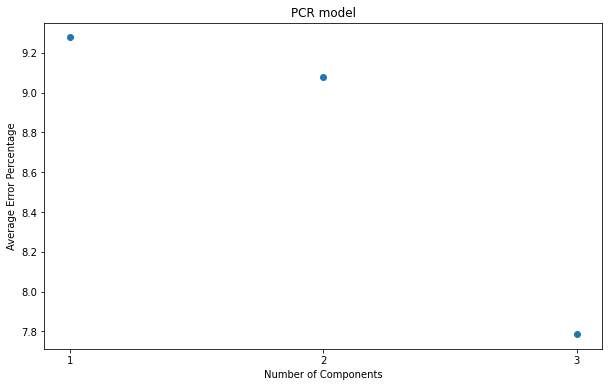

In [26]:
# Plot Average Error percentage vs number of components used in PCR
n_comp = np.arange(1,4)

plt.figure(figsize=(10,6))
plt.title('PCR model')
plt.scatter(n_comp, pca_error_avg)
plt.ylabel("Average Error Percentage")
plt.xlabel("Number of Components")
plt.xticks(range(1,4))
plt.show()

In [37]:
# get difference in occupancy percentage accross 12 blocks paid week
# average out difference across each hour
index_time = np.arange(8,20,1)

diff = Y - X[:,2]
print(diff)
print(diff.shape)

[0.464 0.464 0.429 ... 0.    0.    0.   ]
(60480,)


In [53]:
avg_diff = diff.reshape(12,5040).transpose()
print(avg_diff)

[[ 0.464  0.286  0.25  ...  0.291  0.384  0.25 ]
 [ 0.464  0.286  0.25  ...  0.291  0.384  0.25 ]
 [ 0.429  0.143  0.25  ...  0.291  0.231  0.167]
 ...
 [ 0.714  0.714 -0.25  ...  0.25   0.846  0.   ]
 [ 0.714  0.714 -0.167 ...  0.25   0.846  0.   ]
 [ 0.714  0.857 -0.167 ...  0.25   0.923  0.   ]]


In [54]:
times = []
for i in range(0, len(naive_occ.index)):
    times.append(naive_occ.index[i])
occ_diff = pd.DataFrame(avg_diff, columns=cap_ref.index)
occ_diff.index = times
occ_diff

,11TH AVE NE BETWEEN NE 47TH ST AND NE 50TH ST,15TH AVE NE BETWEEN NE 43RD ST AND NE 45TH ST,1ST AVE BETWEEN BELL ST AND BATTERY ST,2ND AVE BETWEEN LENORA ST AND BLANCHARD ST,6TH AVE N BETWEEN JOHN ST AND THOMAS ST,7TH AVE BETWEEN OLIVE WAY AND STEWART ST,BOYLSTON AVE BETWEEN E PIKE ST AND E PINE ST,EASTLAKE AVE E BETWEEN ALOHA ST AND WARD ST,FAIRVIEW AVE N BETWEEN JOHN ST AND THOMAS ST,FAIRVIEW NR AVE N BETWEEN FAIRVIEW PL N AND ALOHA ST,MINOR AVE BETWEEN HOWELL ST AND STEWART ST,ROY ST BETWEEN FAIRVIEW AVE N AND MINOR AVE N
2022-03-21 08:00:00,0.464,0.286,0.250,0.625,-0.316,0.75,0.667,0.417,0.084,0.291,0.384,0.250
2022-03-21 08:01:00,0.464,0.286,0.250,0.625,-0.316,0.75,0.667,0.417,0.084,0.291,0.384,0.250
2022-03-21 08:02:00,0.429,0.143,0.250,0.625,-0.369,0.75,0.667,0.417,0.084,0.291,0.231,0.167
2022-03-21 08:03:00,0.429,0.143,0.250,0.625,-0.369,0.75,0.667,0.417,0.084,0.291,0.154,0.167
2022-03-21 08:04:00,0.429,0.143,0.250,0.625,-0.369,0.75,0.667,0.417,0.084,0.291,0.154,0.083
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 19:55:00,0.714,0.571,-0.250,0.500,0.000,-0.25,0.000,0.000,0.250,0.250,0.846,0.000
2022-03-28 19:56:00,0.714,0.714,-0.250,0.500,0.000,-0.25,0.000,0.000,0.333,0.250,0.846,0.000
2022-03-28 19:57:00,0.714,0.714,-0.250,0.500,0.000,-0.25,0.000,0.000,0.333,0.250,0.846,0.000
2022-03-28 19:58:00,0.714,0.714,-0.167,0.500,0.000,-0.25,0.000,0.000,0.333,0.250,0.846,0.000


In [56]:
#occ_diff.to_csv('./difference_occupancy.csv')

In [87]:
# test hot encoding 3/22/2022 and 3/23/2022
days_encode = []

for name, column in naive_occ.iteritems():
    for index in naive_occ.index:
        date = index.strftime('%Y%m%d')
        if(date == '20220322'):
            days_encode.append([1,0])
        elif(date == '20220323'):
            days_encode.append([0,1])
        else:
            days_encode.append([0,0])

days_encode = np.array(days_encode)
print(days_encode.shape)

(60480, 2)


In [147]:
X_encode = np.concatenate((X, days_encode), axis=1)
print(X_encode[5780])

[8.20e+02 7.00e+00 1.43e-01 1.00e+00 0.00e+00]


In [130]:
X_en_train, X_en_test, y_en_train, y_en_test = train_test_split(X_encode, Y, test_size=0.20, random_state=42)

In [137]:
component = 5
pcr4 = make_pipeline(StandardScaler(), PCA(n_components=4), LinearRegression())
pcr5 = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())


pcr1.fit(X_en_train, y_en_train)
pcr2.fit(X_en_train, y_en_train)
pcr3.fit(X_en_train, y_en_train)
pcr4.fit(X_en_train, y_en_train)
pcr5.fit(X_en_train, y_en_train)

X_predict1 = pcr1.predict(X_en_test)
X_predict2 = pcr2.predict(X_en_test)
X_predict3 = pcr3.predict(X_en_test)
X_predict4 = pcr4.predict(X_en_test)
X_predict5 = pcr5.predict(X_en_test)

pca_en_error = np.zeros(component)

for i in range(len(y_en_test)):
    pca_en_error[0] += (y_en_test[i] - X_predict1[i])**2
    pca_en_error[1] += (y_en_test[i] - X_predict2[i])**2
    pca_en_error[2] += (y_en_test[i] - X_predict3[i])**2
    pca_en_error[3] += (y_en_test[i] - X_predict4[i])**2
    pca_en_error[4] += (y_en_test[i] - X_predict5[i])**2

pca_en_error_avg = pca_en_error / len(y_en_test) * 100

print(pca_en_error_avg)

[10.01717068  9.2758366   9.07650895  8.64268091  7.78669524]


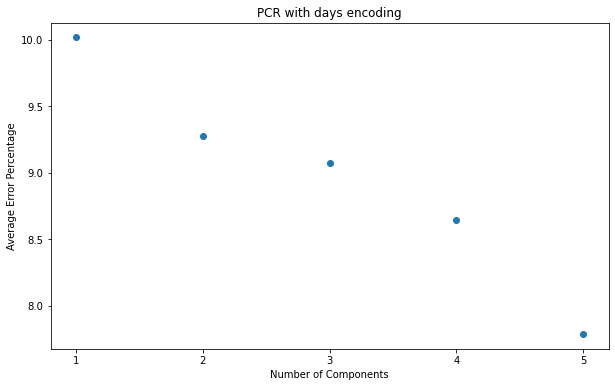

In [138]:
# Plot Average Error percentage vs number of components used in PCR
n_comp = np.arange(1,component+1)

plt.figure(figsize=(10,6))
plt.title('PCR with days encoding')
plt.scatter(n_comp, pca_en_error_avg)
plt.ylabel("Average Error Percentage")
plt.xlabel("Number of Components")
plt.xticks(range(1,component+1))
plt.show()

In [140]:
# ordinary linear regression
theta_hat_en = np.linalg.lstsq(X_en_train, y_en_train, rcond=None)[0]
print(theta_hat_en)

[ 2.35889361e-04 -8.54249098e-05  5.19860503e-01  1.82203179e-02
  1.17273260e-02]


In [141]:
error_en = 0
for i in range(len(y_en_test)):
    error_en += (y_en_test[i] - X_en_test[i,:]@theta_hat_en)**2
error_avg_en = error_en / len(y_en_test) * 100
print(error_avg_en)

9.154310931410475
